In [31]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [157]:
%load_ext autoreload
%autoreload 2
from dataset import *
from video import SimulationVideo
from video import NuscenesVideo, NuscenesVideoDebug, PFVideo, PFXYVideo
from MapMatching import MapMatching

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
import copy
class Simulation():
    def __init__(self, model, **kwargs):
        pass
    
    def run(self, N):
        pass
    
class DynamicSimulation():
    def __init__(self, model, **kwargs):
        self.model = model
        self.dataset = DynamicSimulatedDataset()
        self.video = SimulationVideo()
    
    def run(self, N):
        for t in range(0,N):
            print(f"frame {t}")
            zw, covw, prior, video_data = self.dataset.getData(t)
            print("prior", prior)
            points, polynoms = self.model.run(zw,covw,prior)
            self.video.save(t, prior, video_data, points, polynoms, self.model.getDebugInfo())
            
class NuscenesSimulation():
    def __init__(self, model, scene_id=5, **kwargs):
        self.model = model
        directory = kwargs.pop('directory', r"/home/kfir/workspace/nuScenes/v1.0-trainval")
        self.mm = kwargs.pop('mm', False)
        self.nmax = kwargs.pop('Nmax', 800)
        self.dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=scene_id, N=self.nmax)
        #self.video = NuscenesVideo(history=True, scene=scene)
        #self.video_debug = NuscenesVideoDebug(history=True, scene=scene)
        self.pf_video = PFVideo(history=True, scene=scene, N=self.nmax)
        #self.pf_xy_video = PFXYVideo(history=True, scene=scene, N=self.nmax)
        self.map_matching = MapMatching(N=200)
        self.lane = None
        self.scene = scene
        
    def getBestLane(self, prior):
        if self.lane is None:
                self.lane = prior[0]
                lane = prior[0]
        else:
            for pr in prior:
                if 1:#if np.linalg.norm(self.lane["poly"][1]-pr["poly"][1]) < 2 and np.linalg.norm(self.lane["poly"][0]-pr["poly"][0]) < 0.1:
                    lane = pr
                    self.lane = pr

        lanes = [lane]
        return lanes
    
    def translatePolynom(self, c, xstart, xend, pos):
        x = np.array([xstart, 0.5*(xstart+xend), xend])
        x_trns = x - pos[0]
        y = np.array([c[0]*x[0]**2+c[1]*x[0]+c[2], c[0]*x[1]**2+c[1]*x[1]+c[2], c[0]*x[2]**2+c[1]*x[2]+c[2]])
        y_trns = y - pos[1]
        A = [[x_trns[0]**2, x_trns[0], 1],[x_trns[1]**2, x_trns[1], 1],[x_trns[2]**2, x_trns[2], 1]]
        c = np.linalg.inv(A).dot(y_trns)
        
        return c
        
    def translatePrior(self, pos, prior):
        for pr in prior:
            min_x = np.min(pr["x"])
            max_x = np.max(pr["x"])
            c = self.translatePolynom(pr["poly"].c, min_x, max_x, pos)
            pr["poly"] = np.poly1d(c)
            pr["x"] -= pos[0]
        
        return prior
    
    def translateMeasurements(self, zw, pos):
        return zw - pos
        
    def translateOutput(self, points, polynoms, pos):
        points = points - pos
        for polynom in polynoms:
            c = self.translatePolynom(polynom["f"].c, polynom["x_start"], polynom["x_end"], pos)
            polynom["f"] = np.poly1d(c)
            polynom["x_start"] -= pos[0]
            polynom["x_end"] -= pos[0]
        
        return points, polynoms
        
    def run(self,start, N, generate_video=False, video_with_priors=False, debug=False, translate=True):
        start_idx = start
        first = True
        for t in range(start_idx,start_idx + N):
            print(f"frame {t}")
            zw, covw, prior, video_data, nusc_map = self.dataset.getData(t)
            if first:
                translation = np.array(video_data["pos"][0:2])
                print("translation", translation)
                first = False
                
            #lanes = self.getBestLane(prior)
            lanes = copy.deepcopy(prior)
            if translate:
                lanes = self.translatePrior(translation, lanes)
                zw = self.translateMeasurements(zw, translation)
            prior_list = []
            for lane in lanes:
                (a0,a1,a2) = lane["poly"].c[2], lane["poly"].c[1], lane["poly"].c[0]
                prior_list.append({"c": (a0,a1,a2), "xmin": np.min(lane["x"]), "xmax": np.max(lane["x"])})
    
            points, polynoms = self.model.run(zw,covw,prior_list)
            if translate:
                points, polynoms = self.translateOutput(points, polynoms, -1*translation)
                
            #Run map-matching!
            if self.mm:
                extended_tracks = self.model.getExtendedTracks()
                orig_world_ref = video_data["pos_imu"]
                world_ref = np.array([orig_world_ref[0]-translation[0], orig_world_ref[1]-translation[1]])
                orig_radar_ref = video_data["pos"]
                radar_ref = np.array([video_data["pos"][0]-translation[0], video_data["pos"][1]-translation[1]]) 
                self.map_matching.run(extended_tracks, nusc_map, orig_world_ref, world_ref, orig_radar_ref, radar_ref, video_data["rot_imu"], video_data["heading_imu"], video_data["odometry"])
            
            try:
                self.video.save(t,video_data, polynoms, nusc_map, video_with_priors=video_with_priors)
            except:
                pass
            try:
                self.video_debug.save(t,video_data, polynoms,points, nusc_map,self.model.getDebugInfo(), video_with_priors=video_with_priors)
            except:
                pass

            if self.mm:
                mm_results = self.map_matching.getResults()
                mm_results["pf_best_pos"] += translation[0:2]
                mm_results["pf_mean_pos"] += translation[0:2]
                print("mm_results[pf_mean_pos]", mm_results["pf_mean_pos"], "IMU pos", video_data["pos_imu"], "GT", video_data["pos"])
                self.pf_video.save(t,video_data, mm_results, polynoms, nusc_map)
                try:
                    self.pf_xy_video.save(t,video_data, mm_results, polynoms, nusc_map)
                except:
                    pass
        
        if generate_video:
            try:
                self.video.generate(name=f"video\scene{self.scene}.avi", fps=5)
            except:
                pass
            try:
                self.video_debug.generate(name=f"video\scene{self.scene}_debug.avi", fps=5)
            except:
                pass
            try:
                self.pf_video.generate(name=f"video\scene{self.scene}_debug.avi", fps=5)
            except:
                pass

scene_id=690 scene_name=scene-0904 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:294: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 ...
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]]


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])


frame 0


/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


translation [1114.93531372 1589.04348036]
Number of point tracks before run() 0
Number of extended tracks before run() 0
mm_results[pf_mean_pos] [1114.92609282 1589.04634629] IMU pos [1114.935313715233, 1589.04348036164, 0.0] GT [1114.935313715233, 1589.04348036164, 0.0]


frame 1
Number of point tracks before run() 45
Number of extended tracks before run() 0
mm_results[pf_mean_pos] [1115.13305531 1588.92957384] IMU pos [1115.14118574 1588.92638785    0.        ] GT [1115.1150744786937, 1588.9425405321585, 0.0]
frame 2
Number of point tracks before run() 69
Number of extended tracks before run() 0
mm_results[pf_mean_pos] [1115.31828741 1588.82591592] IMU pos [1115.32783782 1588.82023223    0.        ] GT [1115.2970516643607, 1588.8407500709554, 0.0]
frame 3
Number of point tracks before run() 79
Number of extended tracks before run() 0
created an extended object! [-4.78771627e+00 -5.87142453e-01 -7.12189712e-04  3.69219058e+01
  5.33584103e+01] static_cars_flag True
mm_results[pf_mean_pos] [1115.51297763 1588.7155985 ] IMU pos [1115.51629836 1588.71310493    0.        ] GT [1115.495264538025, 1588.7289809305764, 0.0]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


n_polynoms 1 cost_true [1.5439982240943884] cost_mean [1.546250649842962]
frame 4


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 81
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


mm_results[pf_mean_pos] [1115.7252619  1588.59773269] IMU pos [1115.73496903 1588.58890063    0.        ] GT [1115.7049531624352, 1588.6101874969293, 0.0]
n_polynoms 1 cost_true [1.4026060515578327] cost_mean [1.3933177532971146]
frame 5
Number of point tracks before run() 102
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Tracks are similar! do not open a new trk (-0.573786105156862, -0.7085527379176427, 0.002205079737132738) (0.0, -0.8802341791291827, 0.008321487253674185)
mm_results[pf_mean_pos] [1115.91953541 1588.47823854] IMU pos [1115.93919186 1588.47298227    0.        ] GT [1115.9097254822852, 1588.4937046859936, 0.0]
n_polynoms 1 cost_true [1.3179400486015729] cost_mean [1.3153094027233063]
frame 6
Number of point tracks before run() 102
Number of extended tracks before run() 1
Updating extended object tr

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1118.49569428 1586.97712443] IMU pos [1118.52664001 1586.99415205    0.        ] GT [1118.5705980106864, 1586.9597885845649, 0.0]
n_polynoms 2 cost_true [1.0990407973730976, 1.575324181214165] cost_mean [1.0853369062957574, 1.5978086847674553]
frame 15


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


mm_results[pf_mean_pos] [1118.76869218 1586.80955248] IMU pos [1118.80145015 1586.83365517    0.        ] GT [1118.818849313308, 1586.8157753634828, 0.0]
n_polynoms 2 cost_true [1.391805220488719, 1.8162156194739258] cost_mean [1.371235401150913, 1.8138330345932974]
frame 16
Number of point tracks before run() 191
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
mm_results[pf_mean_pos] [1119.05387515 1586.64070875] IMU pos [1119.08090737 1586.66989717    0.        ] GT [1119.0694042606774, 1586.6682215465112, 0.0]
n_polynoms 2 cost_true [1.1127460207038027, 2.899566671132839] cost_mean [1.0912244171507144, 2.855924023712757]
frame 17
Number of point tracks before run() 189
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
mm_results[pf_mean_pos] [1119.58509125 1586.3236399 ] IMU pos [1119.6

frame 33
Number of point tracks before run() 178
Number of extended tracks before run() 2
Updating extended object track =  1
mm_results[pf_mean_pos] [1125.04411945 1582.97592622] IMU pos [1124.94383096 1583.11457177    0.        ] GT [1124.8819027476347, 1583.1046850155992, 0.0]
n_polynoms 2 cost_true [1.1046768846475288, 5.0951967340775886] cost_mean [1.0922602931713972, 4.156934703259436]
frame 34
Number of point tracks before run() 180
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
mm_results[pf_mean_pos] [1125.68702472 1582.57420664] IMU pos [1125.58562981 1582.71590937    0.        ] GT [1125.5535056920023, 1582.6857535147433, 0.0]
n_polynoms 2 cost_true [1.2964780066301596, 2.4982241376775054] cost_mean [1.2769571939606748, 2.1148638018959947]
frame 35
Number of point tracks before run() 180
Number of extended tracks before run() 2
Updating ex

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1130.41041384 1579.64078693] IMU pos [1130.17740859 1579.88313258    0.        ] GT [1130.1286220734262, 1579.7753986631794, 0.0]
n_polynoms 3 cost_true [1.1233299721719612, 3.612353404267052, 1.9038113742315648] cost_mean [1.1594072724999247, 2.6608759477285293, 1.7458457131317857]
frame 47


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


mm_results[pf_mean_pos] [1130.73663643 1579.43928546] IMU pos [1130.49270977 1579.68901007    0.        ] GT [1130.4788176021211, 1579.5515683136518, 0.0]
n_polynoms 3 cost_true [1.4802979902202245, 2.7340957651831066, 2.169568924323135] cost_mean [1.529272942680542, 2.21759901937116, 1.8447250503914545]
frame 48
Number of point tracks before run() 178
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
mm_results[pf_mean_pos] [1131.11971532 1579.20631763] IMU pos [1130.85699958 1579.46489146    0.        ] GT [1130.829051011404, 1579.32654967813, 0.0]
n_polynoms 3 cost_true [1.0854913618053132, 3.9256319839624982, 3.0051563508243495] cost_mean [1.133340136242434, 3.0241316118951116, 2.3754983695308334]
frame 49
Number of point tracks before run() 181
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  2
Updating extended object tra

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1133.55050462 1577.68761512] IMU pos [1133.25145858 1577.98452465    0.        ] GT [1133.1648463111883, 1577.8133505723295, 0.0]
n_polynoms 4 cost_true [1.2735562911900176, 2.0897147578894217, 1.8849586638201368, 2.229145283396069] cost_mean [1.315560213901871, 1.9447466981054304, 1.7465419018294739, 2.356395711274487]
frame 55


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


mm_results[pf_mean_pos] [1133.92558937 1577.45366235] IMU pos [1133.62020345 1577.75389898    0.        ] GT [1133.4950815718225, 1577.592704249017, 0.0]
n_polynoms 4 cost_true [1.3183642876999586, 2.355609054411833, 2.0315283080286792, 1.6710514626366015] cost_mean [1.3681907406490557, 2.0139846008601094, 1.686809547633066, 1.821023975797613]
frame 56
Number of point tracks before run() 178
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Tracks are similar! do not open a new trk (-0.9959671155929595, -0.7403247740479092, 0.0035653460047696196) (0.0, -0.691895926725044, 0.0018684795899501035)
mm_results[pf_mean_pos] [1134.25265268 1577.24828748] IMU pos [1133.93862252 1577.55424289    0.        ] GT [1133.8092858555174, 1577.383419110097, 0.0]
n_polynoms 4 cost_true [1.53920569906

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1134.99358339 1576.77815961] IMU pos [1134.67888039 1577.08794467    0.        ] GT [1134.509671155001, 1576.9211939012584, 0.0]
n_polynoms 5 cost_true [1.3333671228418464, 1.9320131995515906, 1.6997443158375445, 1.97094081070752, 1.9057543854540688] cost_mean [1.3989315090463423, 1.7724706895437459, 1.5456737117067503, 2.163677411135427, 2.08156134143524]
frame 58


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


mm_results[pf_mean_pos] [1135.32909925 1576.56443056] IMU pos [1135.00637806 1576.88102553    0.        ] GT [1134.8547391301358, 1576.6943780825814, 0.0]
n_polynoms 5 cost_true [1.2772977912022445, 2.9413826166893764, 2.018049604456211, 1.6133022267902677, 1.4385911145204457] cost_mean [1.4096804236967597, 2.0029977991568706, 1.6017753533721633, 1.7792000680571114, 1.5600101776765745]
frame 59
Number of point tracks before run() 185
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3
Tracks are similar! do not open a new trk (-0.8834070226972719, -0.7399675954129806, 0.0035864392647308087) (0.0, -0.6488499928555218, -0.00018507459932326053)
mm_results[pf_mean_pos] [1135.70456179 1576.32299311] IMU pos [1135.37786

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1137.11143094 1575.41986834] IMU pos [1136.78007062 1575.75262204    0.        ] GT [1136.5591053368653, 1575.5452470825244, 0.0]
n_polynoms 6 cost_true [1.2209339803591048, 2.798000981710807, 2.050997510047673, 2.238456122987037, 1.9205116879936555, 1.868097732999372] cost_mean [1.4288606659875007, 2.144307160682047, 1.763941747619512, 2.4474947254805066, 2.1286762890056634, 2.01591555003415]
frame 63


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.7967733330964102, -0.7419277991724913, 0.003603521173626113) (0.0, -0.6498738955390693, -0.0003499683635482356)
mm_results[pf_mean_pos] [1137.44264627 1575.20311747] IMU pos [1137.10824289 1575.54271637    0.        ] GT [1136.8997918523992, 1575.3156019717517, 0.0]
n_polynoms 6 cost_true [1.0942850616351085, 4.056656420860279, 2.6023273568302128, 2.0987500043384872, 1.907093353741931, 1.8770447825992918] cost_mean [1.2310062403046118, 2.7820105222557405, 2.094600671488794, 2.293267530135146, 2.128330837872089, 2.0772361348947754]
frame 64
Number of point tracks before run() 153
Number of extended tracks before run() 6
Updating extended object track =  2
created an extended object! [-7.41519520e+01  3.18241571e+00 -5.24148677e-02  2.61105605e+01
  3.52855974e+01] static_cars_flag False


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1137.82346105 1574.95939293] IMU pos [1137.48124197 1575.3036993     0.        ] GT [1137.2513308041148, 1575.076788007936, 0.0]
n_polynoms 7 cost_true [1.0595092174619583, 1.762763258679658, 1.5894378647878638, 2.0389505351842807, 1.969685375301249, 1.8667221759577874, 1.1018149549669527] cost_mean [1.1615276798433727, 1.6331320127656836, 1.4639097517883985, 2.302074240896324, 2.2201964661504294, 2.0746773893050565, 1.2196445144037302]
frame 65


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.2178251280387065, -0.7403455501526133, 0.0036035211736260802) (0.0, -0.6684128059320338, -7.99723709460862e-05)
mm_results[pf_mean_pos] [1138.22532254 1574.70072414] IMU pos [1137.87350641 1575.05205486    0.        ] GT [1137.5997566904377, 1574.8417373083644, 0.0]
n_polynoms 7 cost_true [1.0990596327842437, 2.1481144712796056, 1.794330537939946, 2.2326478487081296, 1.9076341099429022, 1.7942074837180533, 1.3293189570068826] cost_mean [1.2802414905581467, 1.891730555375539, 1.5968388304600327, 2.5510860794139476, 2.1698706064365827, 2.062430289150701, 1.2439093622240078]
frame 66
Number of point tracks before run() 144
Number of extended tracks before run() 7
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  2
mm_results[pf_mean_pos] [1138.54986675 1574.48929988] IMU pos [1138.19161375 1574.84780843    0.        ] GT [1137.9452442477564, 1574.609263

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1139.66925184 1573.7814029 ] IMU pos [1139.29552564 1574.1459995     0.        ] GT [1138.9832415376795, 1573.9093213230176, 0.0]
n_polynoms 8 cost_true [1.2052576324669952, 2.414523653446924, 1.7365556737582477, 1.9119368799259797, 1.5887509698054603, 1.5191587827791397, 1.269987717119676, 1.6446914070560585] cost_mean [1.4272353533185473, 1.8282295187186726, 1.621942421692135, 2.251274828645037, 1.8974909450917896, 1.8126306923834188, 1.3031628906777797, 1.8975465387503334]
frame 69


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 8
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.9503296445251634, -0.7416906295053506, 0.003615675753109582) (0.0, -0.666211852170063, 6.971839192508657e-05)
mm_results[pf_mean_pos] [1140.04198924 1573.54338191] IMU pos [1139.67473708 1573.90682885    0.        ] GT [1139.3591458481933, 1573.662333301878, 0.0]
n_polynoms 8 cost_true [1.1131464068779615, 2.227413800040576, 1.7615206083442807, 1.896389202719322, 1.7083736151761435, 1.575069924049712, 1.838228815362129, 1.6393113433165283] cost_mean [1.3099163142865267, 2.0269424414640884, 1.455641574223911, 2.2348730273265325, 1.967082865862033, 1.8920427761090266, 2.3632473275613055, 1.945490466046309]
frame 70
Number of point tracks before run() 135
Number of extended tracks before run() 8
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  3
Tracks are similar! do not open a new trk (0.42370751377078864, -0.6903574541960579, 0.0009838298937848132) 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1140.73370882 1573.10963587] IMU pos [1140.35487314 1573.47989768    0.        ] GT [1140.0459798226811, 1573.210770097668, 0.0]
n_polynoms 9 cost_true [1.0840661043512785, 4.231010438436902, 2.652769680523121, 2.1615723750714793, 1.802283855639646, 1.9317211464971218, 1.328575390463131, 1.8251115635653086, 3.68184590788722] cost_mean [1.450121935873291, 2.8640222426154445, 2.2402220818492853, 2.5081297595944814, 2.1129659299273325, 2.1974251028912, 1.283150275518795, 2.109689878055153, 2.4431179252157915]
frame 72


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 9
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  7


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2123653196839097, -0.6698813858462702, 0.00035720122572655146) (0.0, -0.7216524677645557, 0.0013041858582574278)
mm_results[pf_mean_pos] [1141.12535228 1572.8614984 ] IMU pos [1140.75075736 1573.23213072    0.        ] GT [1140.4034340681897, 1572.9758869831694, 0.0]
n_polynoms 9 cost_true [1.1506499123650382, 1.8983044701581135, 1.5713428004172922, 2.169626159456603, 2.1694147436526183, 2.016057629298376, 1.2545088918734975, 1.8657830063406802, 1.8318072865617159] cost_mean [1.3630991514759037, 1.758179108384948, 1.482546201358281, 2.545354878573695, 2.5271913129013543, 2.3323190575461386, 1.270146504916836, 2.196506853695846, 1.7088585248549049]
frame 73
Number of point tracks before run() 125
Number of extended tracks before run() 9
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  3
Updating extended object track =  3
Tracks are similar! do not open a new trk (-1.0779630010597987, 

frame 81
Number of point tracks before run() 137
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1
created an extended object! [ 7.51420363e+00 -9.23804634e-01  1.84143713e-03  6.06191540e+01
  8.78931441e+01] static_cars_flag True


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1145.35521107 1570.26695432] IMU pos [1144.91952856 1570.68835165    0.        ] GT [1144.4914211940122, 1570.3200941790788, 0.0]
n_polynoms 8 cost_true [1.7825447034543973, 2.365016561620623, 2.394108777478199, 2.047886496483328, 1.2504340406795884, 2.0309109163838865, 2.5202333066212512, 2.0388179267135214] cost_mean [1.2629090524237463, 2.9569217529347718, 2.7742965423744828, 2.4938610463984916, 1.265882697907175, 2.5085202445049886, 1.9970614723537705, 2.525736146237367]
frame 82


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 8
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.79770358e+00 -5.13780485e-01 -8.84360750e-04  6.93780957e+01
  1.00799681e+02] static_cars_flag True


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1145.71282992 1570.04573931] IMU pos [1145.28410478 1570.46962406    0.        ] GT [1144.8765589562618, 1570.075643637106, 0.0]
n_polynoms 8 cost_true [1.4809035713884786, 1.954847896158139, 1.8487177797315768, 1.404800294367021, 1.5191701821163144, 1.8827065882839988, 1.5226240578426375, 1.339988005881272] cost_mean [1.5172580755730907, 2.504190378370012, 2.3663960501663976, 1.8315092455021456, 1.9654047884388368, 1.9168625527173957, 1.9904414574765852, 1.7897491297556982]
frame 83


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 8
Updating extended object track =  7
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  7
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.7119962429589934, -0.6380896342763259, -0.00023563016993421312) (0.0, -0.6733778884796237, 0.0004082632639337019)
mm_results[pf_mean_pos] [1146.13269967 1569.79188662] IMU pos [1145.70157138 1570.21988767    0.        ] GT [1145.3006336694039, 1569.8162269263871, 0.0]
n_polynoms 8 cost_true [1.7235413540387576, 2.4006708173692997, 2.3595998994722955, 2.1631430162067216, 2.032660429996712, 2.256220271590781, 2.211901176508317, 1.9042719112961912] cost_mean [1.7371059541323366, 2.9976817538703866, 2.945222630191435, 2.6434753305418024, 2.551980161316371, 2.256123190567351, 2.7226375459736913, 2.4396276350175365]
frame 84
Number of point tracks before run() 155
Number of extended tracks before run() 8
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track

frame 92
Number of point tracks before run() 148
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
mm_results[pf_mean_pos] [1150.56219315 1567.13870882] IMU pos [1150.18090179 1567.5721303     0.        ] GT [1149.6412592858746, 1567.127128282019, 0.0]
n_polynoms 6 cost_true [2.0401833735820896, 1.9406922562885105, 1.477651149045342, 1.6084184479299006, 1.7076857367716438, 1.4391802653914416] cost_mean [2.722796223510831, 2.5562741269652114, 2.0262868487100456, 2.1845939532082306, 2.326096103041225, 1.9539640167444687]
frame 93
Number of point tracks before run() 167
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1152.24253749 1566.13965952] IMU pos [1151.85411199 1566.58800865    0.        ] GT [1151.304094605904, 1566.09492139247, 0.0]
n_polynoms 7 cost_true [2.13269835659029, 2.154951057219943, 1.961322052370409, 1.8248882251068044, 2.098926496917386, 1.7002055230263808, 0.7007334355230134] cost_mean [2.8406356878527195, 2.8242234552954386, 2.5536481882434128, 2.455735753365187, 2.7192276812274354, 2.330493101989192, 0.8986150860455747]
frame 96


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.23963446467361033, -0.7533371393739371, 0.004343197552050402) (0.0, -0.655445893519706, 0.00010891733172446)
mm_results[pf_mean_pos] [1152.68757086 1565.87489455] IMU pos [1152.3007034  1566.32502694    0.        ] GT [1151.7166906973284, 1565.8395829564638, 0.0]
n_polynoms 7 cost_true [2.3537157145810186, 2.101935015170402, 1.6839560924062766, 1.8527244404708751, 1.9911972125877369, 1.773722416928787, 0.9922994175688273] cost_mean [3.157561051023602, 2.9040198318458983, 2.346346822996911, 2.4986246174854894, 2.6615857733042247, 2.4421924547021243, 1.4347839524747386]
frame 97
Number of point tracks before run() 146
Number of extended tracks before run() 7
Updating extended object track =  6
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Tracks are similar! do not open a new trk (0.4177956307617918, -0.7377505127944056, 0.0023121969948292726) (0.0, -0.679705784217127, 0.00073569778

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1153.54300959 1565.36262014] IMU pos [1153.16388068 1565.81677597    0.        ] GT [1152.541389532897, 1565.335560940804, 0.0]
n_polynoms 8 cost_true [2.349287781112569, 2.3302988121066797, 1.9758428833105812, 2.1232471766084124, 2.1463044694186277, 2.106202479253903, 1.1042586061339212, 1.7826205900213563] cost_mean [3.0978053433979897, 3.0575351401150703, 2.549395326555166, 2.732216242457022, 2.818142557881326, 2.801607470516916, 1.503542978686243, 2.2911607963629588]
frame 99


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 8
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.37802991231187427, -0.7261414289287408, 0.0022024167067679957) (0.0, -0.634618104796105, -0.0004610121194719453)
mm_results[pf_mean_pos] [1153.91273286 1565.13731784] IMU pos [1153.55462903 1565.58637832    0.        ] GT [1152.9591300154634, 1565.0745974320373, 0.0]
n_polynoms 8 cost_true [1.9275417758814655, 1.8794503770144328, 1.3743652980994658, 1.503300515901581, 1.6285560343679095, 1.4012524039467087, 0.7608634980412086, 1.3328382679009487] cost_mean [2.6636246575476337, 2.57922106622769, 1.9667920805166987, 2.0960591503585446, 2.293552440315147, 2.0065111285320647, 1.0109582645691704, 1.648493348214137]
frame 100
Number of point tracks before run() 152
Number of extended tracks before run() 8
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Tracks are similar! do not ope

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1156.07170007 1563.83789614] IMU pos [1155.73206985 1564.29164099    0.        ] GT [1155.0412265832863, 1563.766103938381, 0.0]
n_polynoms 9 cost_true [2.179929135164544, 2.1201384098711356, 1.554973045610737, 1.7010402247081555, 1.8037639234188079, 1.628453403833609, 0.8018451764157425, 1.4503959441307048, 1.8612987768317013] cost_mean [3.062614055197768, 2.9280565937451466, 2.289949951812252, 2.4400196641596086, 2.613302274754238, 2.3401836337681883, 1.1212737129619343, 1.8659492547614476, 1.6529404286648262]
frame 104


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 9
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.1376869837420678, -0.6069462955997134, -0.0014114305333914458) (0.0, -0.7217764726655779, 0.001280861288031347)
mm_results[pf_mean_pos] [1156.53255749 1563.55616888] IMU pos [1156.20261257 1564.01045873    0.        ] GT [1155.4671955229405, 1563.4994383814565, 0.0]
n_polynoms 9 cost_true [2.6736411059271936, 2.4497518339043007, 1.843453951961153, 2.022172907577506, 2.123618132366243, 2.2233871257580753, 1.2818031443385132, 1.7795591279144203, 1.8248294692552975] cost_mean [3.672125765138825, 3.4455019294939406, 2.5085519738054125, 2.7414381930174696, 2.83363884089081, 2.9382427904423487, 1.7165378165175236, 2.3552363117225976, 1.6661015540859445]
frame 105
Number of point tracks before run() 151
Number of extended tracks before run() 9
Updating extended object track =  7
Updating extended object track =  8
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  3
Updating extended object tr

frame 112
Number of point tracks before run() 140
Number of extended tracks before run() 8
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  7
mm_results[pf_mean_pos] [1160.87699099 1560.89456698] IMU pos [1160.56743808 1561.37266855    0.        ] GT [1159.781362274362, 1560.7635093986412, 0.0]
n_polynoms 8 cost_true [2.3496187687938823, 2.2884133773910937, 1.7149531280001924, 1.83746235229759, 2.025764119188506, 1.8103456914284903, 1.5455998807133544, 1.8312444326202486] cost_mean [3.4045724443104888, 3.2177859037350545, 2.5904241580761207, 2.7581814796076816, 3.055168183840958, 2.710102983259167, 2.043456359600721, 1.6666288621759648]
frame 113
Number of point tracks before run() 163
Number of extended tracks before run() 8
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object tr

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1163.94110212 1559.00986092] IMU pos [1163.65930584 1559.47823619    0.        ] GT [1162.8229842817009, 1558.8330646393063, 0.0]
n_polynoms 9 cost_true [2.2660428080152784, 2.087123161718842, 1.583750075511386, 1.744738335138505, 1.9349997313677447, 1.7566181418603466, 1.5413375195720136, 1.8090975619217282, 2.2245736735084707] cost_mean [3.3739994775822844, 3.1772969891597174, 2.4632620436306674, 2.621534517233869, 2.9546756480871514, 2.7579187566871166, 2.018250813424715, 1.6143049036199006, 3.2594491864811097]
frame 119


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 9
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


mm_results[pf_mean_pos] [1164.39172839 1558.72365009] IMU pos [1164.12303157 1559.19299292    0.        ] GT [1163.261045187343, 1558.5505149937535, 0.0]
n_polynoms 9 cost_true [2.126828384549655, 1.930972372213877, 1.402934843268598, 1.5369392791826566, 1.868530633530997, 1.8224411788566885, 1.5317769346284902, 1.82705214351389, 1.8008988427951085] cost_mean [3.2592356875060733, 2.8823582048542473, 2.2156650175158763, 2.4399724456858443, 2.7982779887394504, 2.674124636916256, 2.0148987746460216, 1.6534000694789572, 2.7131299404625726]
frame 120
Number of point tracks before run() 157
Number of extended tracks before run() 9
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  8
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track =  3
Updating extended object track =  8
Updating extended object track =  8
Updatin

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1165.71841119 1557.89889248] IMU pos [1165.45399597 1558.37257672    0.        ] GT [1164.5467283261105, 1557.7290265519907, 0.0]
n_polynoms 10 cost_true [2.5636987537610727, 2.3931337843884526, 1.8197947346726444, 1.9359409116524842, 2.1541032161430347, 2.2728712942104745, 1.692423525081991, 1.9620125254146272, 1.8859698287853803, 1.5300122681907042] cost_mean [3.7910576504908127, 3.6257778133329435, 2.8316898773559687, 3.020291065572718, 3.2584204948725644, 3.4027478918318943, 2.20569032869121, 1.6297604360904132, 2.8396846638674056, 2.3884323808775654]
frame 123


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 10
Updating extended object track =  8
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  8
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.7387504616298084, 1.3244091809017533, 0.028270308409166743) (0.0, 1.2025147590988585, 0.06053258712064498)
mm_results[pf_mean_pos] [1166.53895048 1557.38655365] IMU pos [1166.27854979 1557.86259921    0.        ] GT [1165.401298043531, 1557.179468756753, 0.0]
n_polynoms 10 cost_true [2.1197930308696766, 2.11273368100745, 2.0769435748998815, 2.0847429949655907, 2.2797906999655786, 2.31278664608574, 1.6832905168918486, 1.7910527015410884, 1.745265905804955, 1.285230168661611] cost_mean [3.1241409833870604, 3.0718331345815577, 2.882571061489406, 2.952732383698441, 3.1743920969546298, 3.337063905736437, 2.4511333420438914, 1.6521416957056259, 2.711707175164917, 2.099329870376767]
frame 124
Number of point tracks before run() 156
Number of extended tracks before run() 10
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track = 

frame 131
Number of point tracks before run() 169
Number of extended tracks before run() 9
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track =  8
Tracks are similar! do not open a new trk (-0.6127261066775694, -0.7252375170358322, 0.007869583184387241) (0.0, -0.6582660087584071, 0.0031786318214137846)
mm_results[pf_mean_pos] [1170.48512585 1554.9043117 ] IMU pos [1170.26953542 1555.38081267    0.        ] GT [1169.246062086328, 1554.701214216577, 0.0]
n_polynoms 9 cost_true [2.0104123823059115, 1.2621398606070209, 1.432228549602966, 1.6040856422103715, 1.6600211758306032, 1.4867863911598354, 1.8816307566252364, 2.028627900403674, 1.784797625440426] cost_mean [3.1164635173298643, 2.120733108252995, 2.3619374038305367, 2.584973804854154, 2.735215328181185, 1.931523445450906, 1.7109641422539388, 3.2186202166962206, 2.7676761451188723]
frame 132
Number of point tracks before run() 163
Number of extended tracks before run() 9
Updating ext

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1172.77154339 1553.45689205] IMU pos [1172.59166766 1553.92452018    0.        ] GT [1171.3485961779143, 1553.3332422562992, 0.0]
n_polynoms 9 cost_true [2.636358150883092, 2.0486578733507326, 2.218591773045865, 2.251034361537773, 2.2627790539250006, 1.782876835418329, 1.9989113063882815, 1.2303763229839924, 1.7734385307053782] cost_mean [3.8517728864216614, 2.8992342661215, 3.120767682756456, 3.2521167932167323, 3.3375124594903727, 1.6306952245883315, 3.1286466463679714, 2.19810248782067, 2.17402318902551]
frame 136


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 9
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  7
Tracks are similar! do not open a new trk (0.2633253479769331, -0.6759435839455558, -6.409552064780962e-05) (0.0, -0.6329633786450576, -0.00044794884741608244)
mm_results[pf_mean_pos] [1173.18116499 1553.18979434] IMU pos [1173.01373263 1553.65911343    0.        ] GT [1171.7695724928885, 1553.0575657908344, 0.0]
n_polynoms 9 cost_true [2.0478378908720933, 1.412289924779039, 1.4988580019381161, 1.6903666953149974, 1.78580044935233, 1.6178945418820048, 2.143065752508925, 1.9125367314425983, 1.8158357072001658] cost_mean [3.302410285416286, 2.3972830189336545, 2.562917805616424, 2.8160159611934814, 2.9241358577584413, 1.7595950844853483, 3.4110770947855777, 3.116861856096813, 2.3667801180635957]
frame 137
Number of point tracks before run() 157
Number of extended tracks before run() 9
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  6
Updating extended object t

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1176.76627509 1550.91470873] IMU pos [1176.61467171 1551.39555432    0.        ] GT [1175.255660505352, 1550.765256252731, 0.0]
n_polynoms 9 cost_true [2.0468189647299413, 2.142821593038412, 2.2705164327203433, 2.214638650988208, 1.9365408438697878, 2.0756209322394175, 1.8861204329042187, 1.6932323670947564, 1.6263521081252936] cost_mean [3.2155800408350337, 3.493045508709049, 3.55468842635365, 3.407584773145543, 1.6551697141407458, 3.4671955966177395, 3.23366108576365, 1.9605667814362533, 1.685458924363216]
frame 144


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 9
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  7
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.11616691934065138, -0.676805533431752, -7.94768628135299e-05) (0.0, -0.5898986805114019, -0.0014618795875530133)
mm_results[pf_mean_pos] [1177.2405963  1550.60821858] IMU pos [1177.09588162 1551.09419194    0.        ] GT [1175.6858473357306, 1550.4839769574137, 0.0]
n_polynoms 9 cost_true [1.6345327381016943, 1.866205046617418, 2.007474321329609, 2.104766235552894, 1.7220974395425435, 2.0111005674426945, 1.375883622618533, 1.6627121975246237, 1.6523695443907047] cost_mean [2.7123013710731994, 2.9435878837175466, 3.16364027019407, 3.3667196069045944, 1.5854568230920414, 3.2489180107953053, 2.343596600251413, 2.174892669142638, 1.7357396080307927]
frame 145
Number of point tracks before run() 146
Number of extended tracks before run() 9
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  8
Updating extended object trac

frame 152
Number of point tracks before run() 158
Number of extended tracks before run() 8
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Tracks are similar! do not open a new trk (-0.49364744838331864, -0.6697899955538131, 0.0018899645229537212) (0.0, -0.6747829092337433, 0.0006070038139087869)
mm_results[pf_mean_pos] [1181.74948503 1547.79020841] IMU pos [1181.5975748  1548.29708112    0.        ] GT [1180.1086163265368, 1547.6101175349568, 0.0]
n_polynoms 8 cost_true [1.6142981590523746, 1.6474464941656366, 1.70837334121833, 1.772500572745134, 2.2466397336485064, 2.0644151658372616, 1.69763034348142, 1.6336477500613276] cost_mean [2.6890023320223526, 2.989403590375509, 3.0947

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1185.30676253 1545.57166494] IMU pos [1185.17857057 1546.08407132    0.        ] GT [1183.5546094368706, 1545.4022492842905, 0.0]
n_polynoms 8 cost_true [1.9274006645984498, 2.193004923490732, 2.295519724435488, 1.6335109390336422, 1.9854045191177985, 1.6428503959821619, 1.7565382261944202, 1.4890100578097174] cost_mean [3.2882477095719134, 3.634522909757073, 3.8487518705774235, 1.7550882809933177, 3.468302138348423, 2.809897889448411, 2.4448294934978696, 2.9243597462460222]
frame 160


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 8
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (1.979687477389037, -0.6765751584085161, -8.130466789735726e-05) (0.0, -0.6181836065290681, -0.0017497424176905361)
mm_results[pf_mean_pos] [1185.71442315 1545.31518318] IMU pos [1185.57890479 1545.83636441    0.        ] GT [1183.9458928417007, 1545.1496551700488, 0.0]
n_polynoms 8 cost_true [1.8369540671325755, 2.196738505895727, 2.2989031365726293, 1.6053164503404895, 2.3014644914038347, 1.8724563543967903, 1.714678521457091, 1.8418386045988195] cost_mean [3.394078909143238, 3.680231447504265, 3.915948292228936, 1.7869205653673719, 3.7540567883043616, 3.36324129538837, 2.475506975777925, 3.299014149609336]
frame 161
Number of point tracks before run() 155
Number of extended tracks before run() 8
Updating extended object track =  1
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  

mm_results[pf_mean_pos] [1190.31047743 1542.41867372] IMU pos [1190.22006786 1542.95532633    0.        ] GT [1188.5398887800836, 1542.171077775591, 0.0]
n_polynoms 7 cost_true [2.463355705221379, 2.5778220623649424, 1.7043145024246489, 2.271833960684414, 1.634845063636504, 1.8178275997364532, 1.719271037202797] cost_mean [4.111320303322535, 4.325791113989648, 1.6566145308365352, 3.95878641463853, 3.253389665335648, 2.5932457476136985, 3.306728194046268]
frame 170
Number of point tracks before run() 167
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  6
Tracks are similar! do not open a new trk (0.24174947894570487, -0.6273755916065139, -0.0011107781842805138) (0.0, -0.6473669136185359, -0.0010508312459244578)
mm_results[pf_mean_pos] [1190.74304981

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1193.59775164 1540.32076878] IMU pos [1193.53662866 1540.87567392    0.        ] GT [1191.8382421730098, 1540.0147960906188, 0.0]
n_polynoms 5 cost_true [2.151478841150032, 1.8507416287319285, 1.8402607881043462, 1.9841626421444634, 2.0090216566916292] cost_mean [4.008576156130942, 3.625370029993335, 2.912611019101397, 3.725214002741532, 3.795445092216585]
frame 177


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


mm_results[pf_mean_pos] [1193.96966854 1540.08353717] IMU pos [1193.91227858 1540.6387972     0.        ] GT [1192.2322675427288, 1539.7572055480068, 0.0]
n_polynoms 5 cost_true [2.102238619698073, 1.853849336695592, 1.7529850652412828, 1.925880422095135, 1.8948443233346914] cost_mean [4.013242442139877, 3.6258870690711436, 2.4358291457591834, 3.6985651537811717, 3.6787680139668772]
frame 178
Number of point tracks before run() 189
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  0
mm_results[pf_mean_pos] [1194.38926517 1539.8181336 ] IMU pos [1194.34755958 1540.36391318    0.        ] GT [1192.6387168788751, 1539.4896142856753, 0.0]
n_polynoms 5 cost_true [1.7993703998175206, 1.3140411528918516, 1.7738787987376496, 1.351603663374941, 1.4154493362432543] cost_mean [3.3434072385403004, 2.704184639971255, 2.6300899776222

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1196.32817012 1538.5597264 ] IMU pos [1196.31998846 1539.11138615    0.        ] GT [1194.6435214466485, 1538.181314283008, 0.0]
n_polynoms 6 cost_true [2.045839746804645, 1.5097875937397218, 1.8784791769700544, 1.6814995945310196, 1.7458632598092725, 0.8212972836054796] cost_mean [3.766959019058905, 3.1310458604768936, 2.922195914457344, 3.326775515055457, 3.454401637191964, 0.9467169621349663]
frame 183


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 199
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.82988132e+01 -1.26572769e+00  3.11809650e-03  9.20433820e+01
  1.03754308e+02] static_cars_flag True


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1196.74098411 1538.29261396] IMU pos [1196.74344126 1538.84144214    0.        ] GT [1195.0361522460287, 1537.922300681003, 0.0]
n_polynoms 7 cost_true [2.104436393767759, 1.8973914118296127, 1.590191719789693, 1.9338433392700523, 1.868330993601144, 0.8131222220432694, 1.9070113488402105] cost_mean [3.9565256888174223, 3.6048642295837254, 2.106787216424023, 3.6515241174716664, 3.5120663834727965, 1.0654272842693129, 3.7022971553177975]
frame 184


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 194
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


mm_results[pf_mean_pos] [1197.10455633 1538.05081379] IMU pos [1197.11150436 1538.60607175    0.        ] GT [1195.4168530513512, 1537.6720729892488, 0.0]
n_polynoms 6 cost_true [2.07642734535637, 1.8503326255840151, 1.6977096024339087, 1.4111153663057492, 0.7087691828827601, 1.4508526599444205] cost_mean [3.995845449522554, 3.585842182524297, 3.347435279086385, 2.740275127277739, 0.8478100754044428, 2.8991028553469995]
frame 185
Number of point tracks before run() 201
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
Tracks are similar! do not open a new trk (0.2073412208380016, 1.547228156105708, -0.003614223143074289) (0.0, 1.6460033221188914, -0.03443399773933364)
mm_results[pf_mean_pos] [1197.87603043 1537.54543209] IMU pos [1197.89645599 1538.10228596    0.        ] GT [1196.1721093046185, 1537.17636225564, 0.0]
n_polynoms 6 cost_true [1.8273894605676404, 1.5883045879677216, 1.56169

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1199.04861618 1536.76998864] IMU pos [1199.09827097 1537.32914707    0.        ] GT [1197.3491153157424, 1536.410141953757, 0.0]
n_polynoms 7 cost_true [1.6509596167942973, 1.2975833575168916, 1.2909176310079045, 1.2215017145847342, 0.6525737498727687, 1.2712736370230375, 1.5297450326806015] cost_mean [3.2429348611331377, 2.6969985808476347, 2.7109750541531463, 2.5144204919100974, 0.6532158465025399, 2.6711553101090235, 2.049014871600673]
frame 189


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 198
Number of extended tracks before run() 7
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.38405889e+02 -5.77923147e+00  1.59558919e-02  1.62205487e+02
  1.69791832e+02] static_cars_flag False


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1199.44262635 1536.50882941] IMU pos [1199.49493006 1537.07291343    0.        ] GT [1197.7254630177836, 1536.162615917202, 0.0]
n_polynoms 8 cost_true [2.1823250705065136, 1.853903183553782, 1.9307364819628545, 1.8769259517347892, 0.8201741901293365, 1.938972774150147, 1.7291803386099085, 1.7922122533317952] cost_mean [4.042973236876408, 3.554239202821771, 3.6288426575534984, 3.381542939285558, 1.070568875710519, 3.6355280592619956, 2.1892557369108916, 2.1818014185226198]
frame 190


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 197
Number of extended tracks before run() 8
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  6
Updating extended object track =  7


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.507817393101465, -0.6015801113378575, 0.015503466155589158) (0.0, -0.5567738011684815, -0.00010741942382755527)
mm_results[pf_mean_pos] [1199.79622634 1536.27699912] IMU pos [1199.85558631 1536.8393518     0.        ] GT [1198.098471063974, 1535.9178824146918, 0.0]
n_polynoms 8 cost_true [2.007147464812976, 1.733342319634839, 1.813654160888912, 1.662424015831628, 0.6401356047930848, 1.746554072455446, 1.6961287560447063, 1.7349511146439163] cost_mean [3.845458263593886, 3.4752923204939954, 3.544512507145135, 3.2620356577045704, 0.914071921869998, 3.453227030175556, 1.956069034674234, 2.429611952519199]
frame 191
Number of point tracks before run() 197
Number of extended tracks before run() 8
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  7
mm_results[pf_mean_pos] [1200.5483559

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1202.08307654 1534.76012151] IMU pos [1202.17388425 1535.33110402    0.        ] GT [1200.3490363979454, 1534.4513951555932, 0.0]
n_polynoms 8 cost_true [1.6199148903095486, 1.279958433209757, 1.2649213390828231, 1.2124709182451334, 0.6557050967705396, 1.5739708992202401, 1.7681712668352003, 1.5133485582853263] cost_mean [3.1021493159095983, 2.5669264701830414, 2.639252282750933, 2.4364314280530754, 0.634029135315564, 2.0054016791387554, 2.0366076241236337, 3.636586544279869]
frame 196


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 191
Number of extended tracks before run() 8
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  6


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.53237260e+01  1.64702510e-01 -2.79125665e-03  1.27895651e+02
  1.43073463e+02] static_cars_flag False


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


mm_results[pf_mean_pos] [1202.42216478 1534.53401103] IMU pos [1202.52173898 1535.10388739    0.        ] GT [1200.7152112275876, 1534.2127800627604, 0.0]
n_polynoms 9 cost_true [2.1365134368763417, 1.7899337920096667, 1.8674858422315688, 1.8563734763310236, 0.8016167219054277, 1.7336454313191696, 1.622670491121373, 1.9953325827299393, 1.613735450726713] cost_mean [3.9038808389592057, 3.448227741146592, 3.5609545255385533, 3.3834770090495985, 1.0238637556912895, 2.2744094411074003, 2.117631131314244, 3.8366474869147593, 2.3141783880081004]
frame 197


/home/kfir/workspace/RadarLocalization/dataset.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 182
Number of extended tracks before run() 9
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


mm_results[pf_mean_pos] [1203.17308462 1534.03934353] IMU pos [1203.28105882 1534.60685812    0.        ] GT [1201.4316948595406, 1533.746127574705, 0.0]
n_polynoms 9 cost_true [2.095689328796737, 1.8080997486532988, 1.7902765674656254, 1.7594377234878675, 0.6171937550085372, 1.6235876662321604, 1.737742000014213, 1.8696320007811245, 1.5847023357372936] cost_mean [3.8583240838621413, 3.3908952496330858, 3.484460663969992, 3.2890217483911512, 0.917661741429028, 1.835784817502837, 1.8546927627772696, 4.2274343573160085, 1.8784425675666072]
frame 198
Number of point tracks before run() 193
Number of extended tracks before run() 9
Updating extended object track =  0
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  0
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track =  8
Updat

KeyboardInterrupt: 

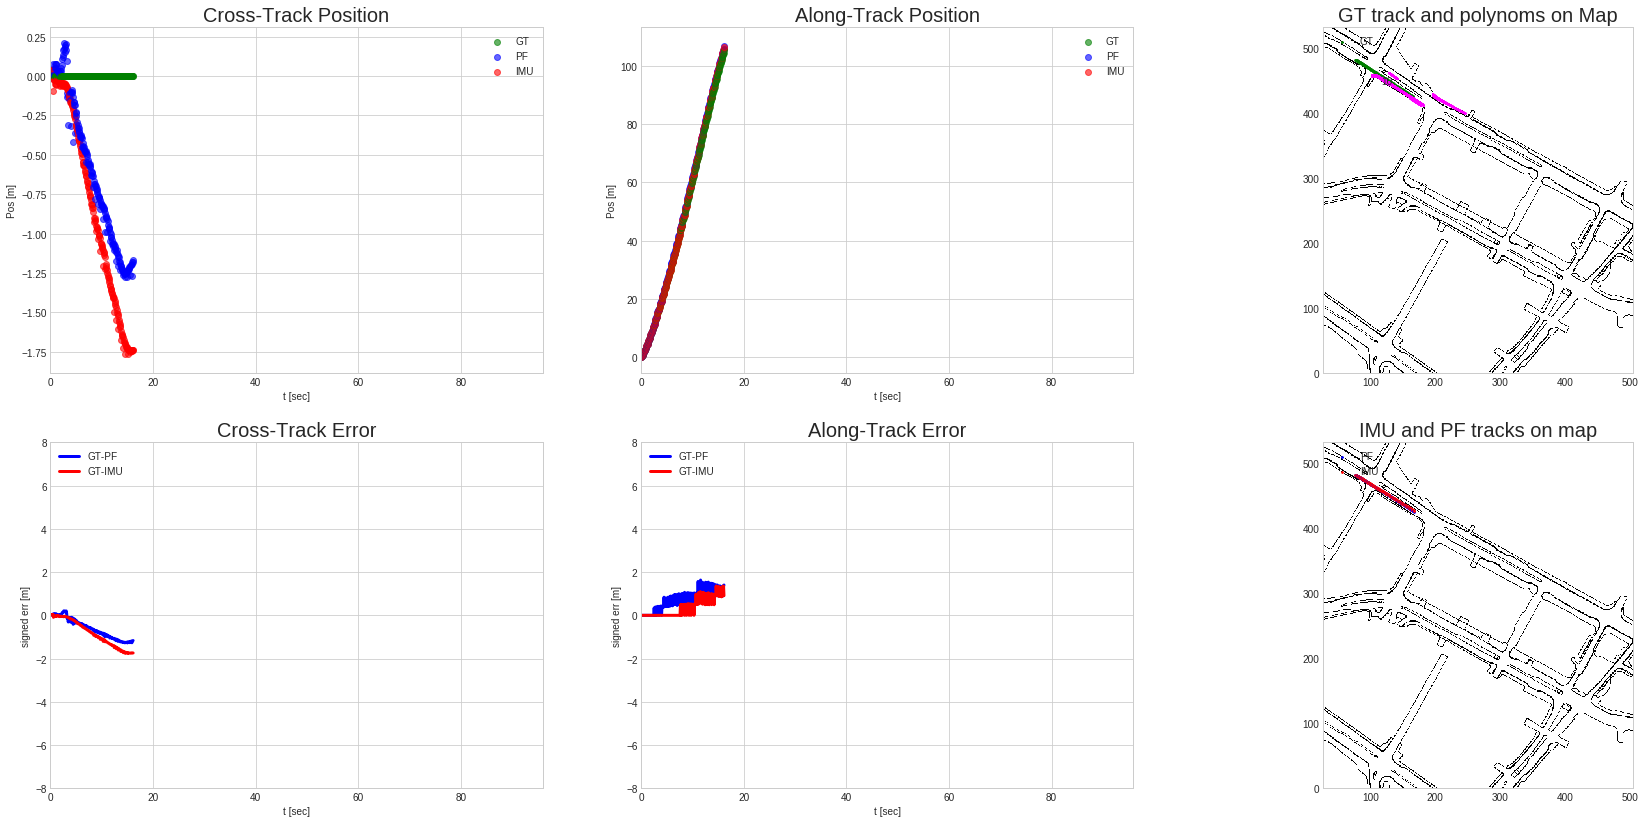

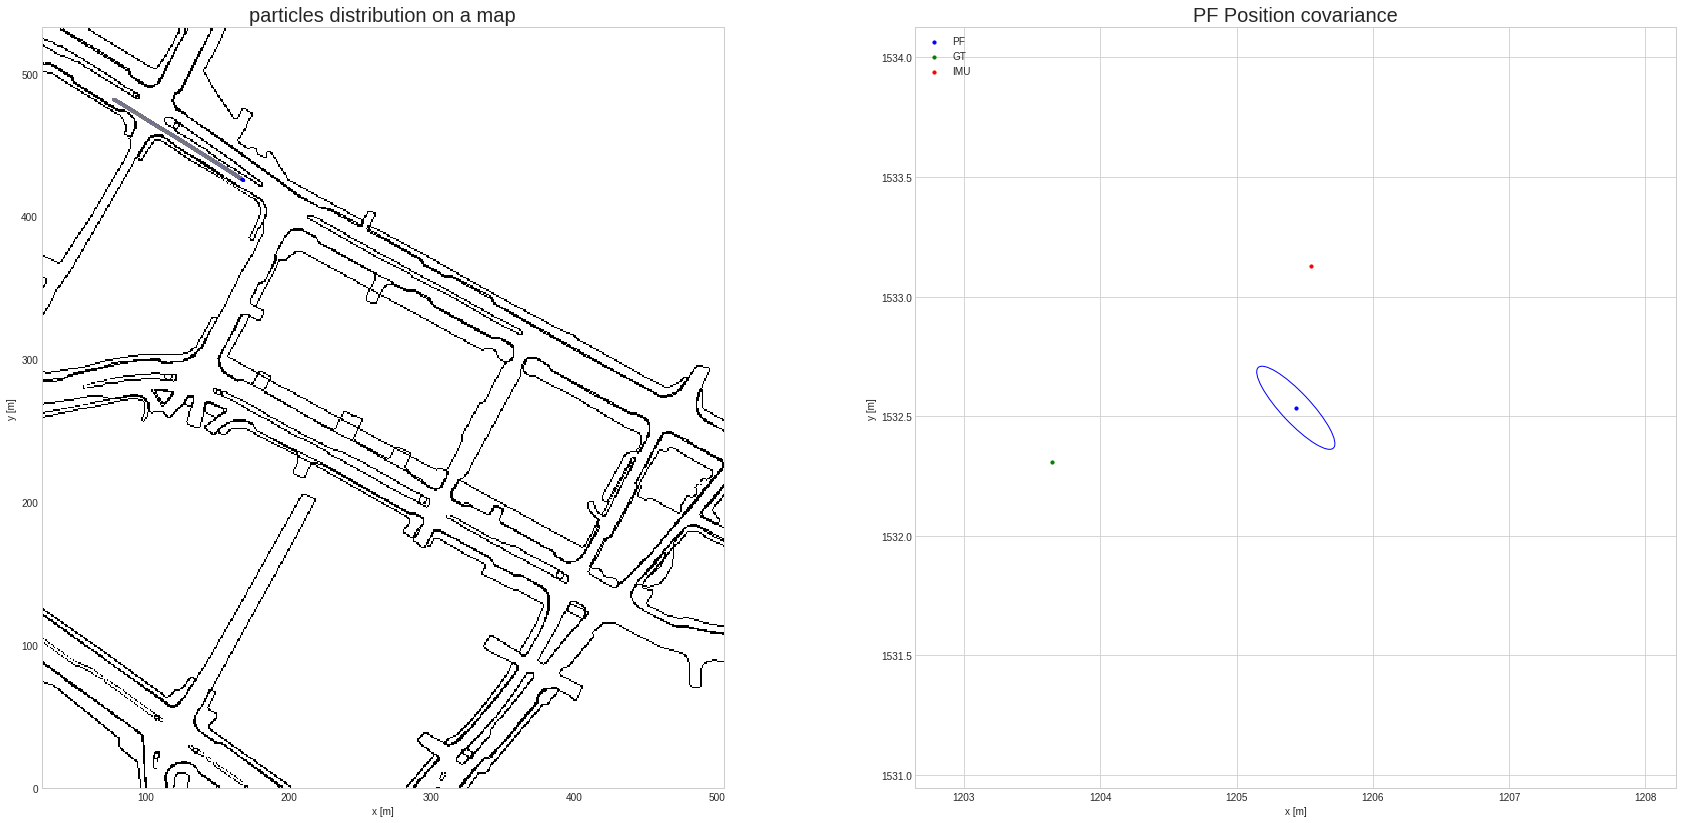

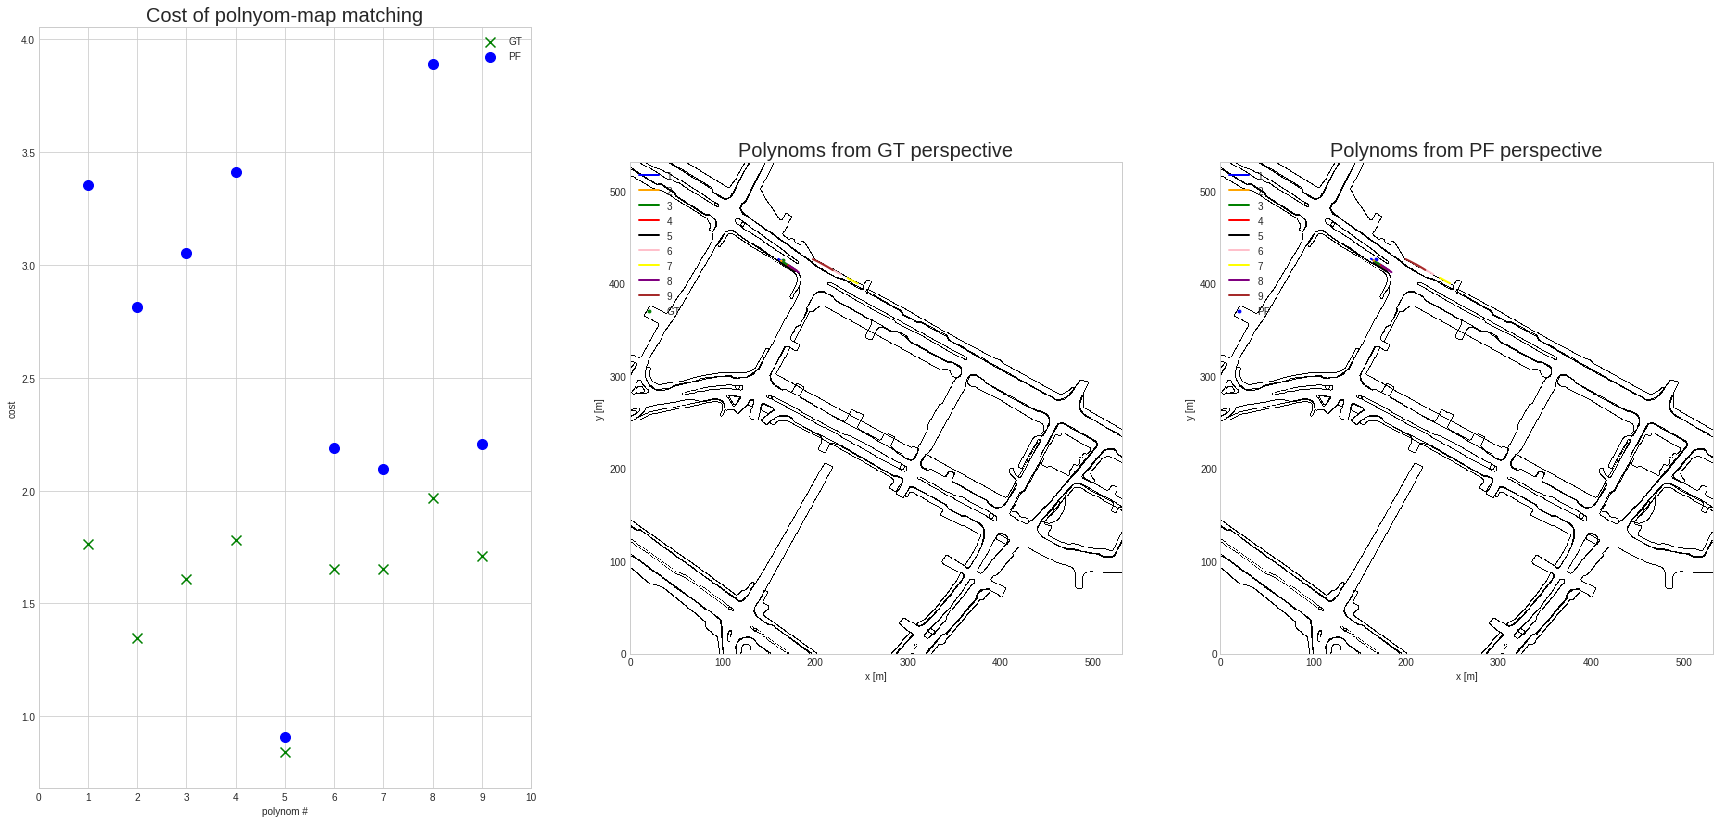

In [159]:
from tracker import Tracker
model = Tracker()
#sim = DynamicSimulation(model)
scene = 690 #365
sim = NuscenesSimulation(model,scene_id=scene, mm=True, Nmax=1200)
sim.run(start=0, N=1200, generate_video=False, video_with_priors=True, debug=False)

In [ ]:
sim.video.generate(name=f"video\scene6_wmap.avi", fps=5)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]
gt [1872.7430668711531, 1071.9499580039733, 0.0] ins [1872.7430668711531, 1071.9499580039733, 0.0]
gt [1872.9656838675555, 1072.1147770276675, 0.0] ins [1872.98214266 1072.12762265    0.        ]
gt [1873.197021748008, 1072.2744418932002, 0.0] ins [1873.26474338 1072.32249811    0.        ]
gt [1873.441761401517, 1072.4343429220644, 0.0] ins [1873.5228249  1072.48639182    0.        ]
gt [1873.702274610831, 1072.5903339908991, 0.0] ins [1873.82757276 1072.66387166    0.        ]
gt [1874.2541783730942, 1072.8830707104162, 0.0] ins [1874.44362047 1072.96742662    0.        ]
gt [1874.5465496397987, 1073.018591867703, 0.0] ins [1874.73675211 1073.09710368    0.        ]
gt [1874.8365718455975, 1073.1359006706575, 0.0] 

gt [1919.240768721885, 1051.3982299692614, 0.0] ins [1921.05246498 1051.51945754    0.        ]
gt [1920.43550779341, 1050.6401859246007, 0.0] ins [1922.26522586 1050.77306746    0.        ]
gt [1921.0387726742154, 1050.2578009934596, 0.0] ins [1922.83346561 1050.42338073    0.        ]
gt [1921.6525444341269, 1049.868272389079, 0.0] ins [1923.48419476 1050.02292154    0.        ]
gt [1922.263063608517, 1049.4769942121188, 0.0] ins [1924.07083828 1049.6619455     0.        ]
gt [1922.8597750514552, 1049.0991385090683, 0.0] ins [1924.71711875 1049.26454964    0.        ]
gt [1923.462421075392, 1048.7163832005515, 0.0] ins [1925.29258452 1048.9108101     0.        ]
gt [1924.6715978329134, 1047.9457771198702, 0.0] ins [1926.5298465  1048.14940737    0.        ]
gt [1925.2767122516616, 1047.5589263694637, 0.0] ins [1927.18888244 1047.74354935    0.        ]
gt [1925.887104397188, 1047.1713267793093, 0.0] ins [1927.7645791  1047.38867673    0.        ]
gt [1926.4990046782855, 1046.77977023

gt [1984.7812947425846, 1010.1274589418626, 0.0] ins [1987.72468557 1010.64821936    0.        ]
gt [1985.3770450527695, 1009.7492021709702, 0.0] ins [1988.31806852 1010.28647794    0.        ]
gt [1986.0421458036114, 1009.3326497257169, 0.0] ins [1989.00934133 1009.86508002    0.        ]
gt [1986.6813547551, 1008.9350548715986, 0.0] ins [1989.6227099  1009.49110625    0.        ]
gt [1987.3127648803172, 1008.541616152962, 0.0] ins [1990.30012483 1009.0779723     0.        ]
gt [1987.9446914064695, 1008.146465483751, 0.0] ins [1990.89812482 1008.7133        0.        ]
gt [1989.2040412244764, 1007.3608406166421, 0.0] ins [1992.1838297  1007.93023034    0.        ]
gt [1989.8316612958643, 1006.9692993569337, 0.0] ins [1992.86416101 1007.51585843    0.        ]
gt [1990.4722083851916, 1006.556223459935, 0.0] ins [1993.46268419 1007.15128169    0.        ]
gt [1991.0901633709964, 1006.1716881471534, 0.0] ins [1994.13627415 1006.74117868    0.        ]
gt [1991.7116995443985, 1005.7815883

gt [2051.264122060744, 968.9419179144304, 0.0] ins [2055.31700827  969.7852148     0.        ]
gt [2052.5233602892877, 968.1569606670542, 0.0] ins [2056.59147059  969.00798925    0.        ]
gt [2053.1541172474635, 967.761067344367, 0.0] ins [2057.20492284  968.63391473    0.        ]
gt [2053.7915617979447, 967.360229256698, 0.0] ins [2057.89089723  968.21580428    0.        ]
gt [2054.421627001507, 966.9670874219858, 0.0] ins [2058.48758541  967.85238119    0.        ]
gt [2055.052537702662, 966.5716693199514, 0.0] ins [2059.1770485   967.43269552    0.        ]
gt [2055.6975527512996, 966.1672092492495, 0.0] ins [2059.77995386  967.06598601    0.        ]
gt [2056.9670603489512, 965.365119365383, 0.0] ins [2061.0575252   966.28990103    0.        ]
gt [2057.6015382733904, 964.9700612132848, 0.0] ins [2061.74572052  965.87213845    0.        ]
gt [2058.235527483056, 964.5776241176768, 0.0] ins [2062.34482993  965.50865248    0.        ]
gt [2058.8639462265737, 964.1937440580077, 0.0]

gt [2105.8298358037023, 935.0039626178104, 0.0] ins [2110.69584933  936.165935      0.        ]
gt [2106.2526677692085, 934.7381752529197, 0.0] ins [2111.0884378   935.92504859    0.        ]
gt [2106.661951466421, 934.4819058275039, 0.0] ins [2111.54409149  935.64541736    0.        ]
gt [2107.0780072294115, 934.2195096339517, 0.0] ins [2111.99704368  935.3674516     0.        ]
gt [2107.4846907223337, 933.9662088847593, 0.0] ins [2112.39877     935.12059135    0.        ]
gt [2108.2862358975626, 933.4610788508512, 0.0] ins [2113.22791549  934.61036066    0.        ]
gt [2108.6844974690557, 933.2119856157867, 0.0] ins [2113.67174823  934.33725562    0.        ]
gt [2109.076214074382, 932.9649753111619, 0.0] ins [2114.06130789  934.09732619    0.        ]
gt [2109.4719559102787, 932.7149544329429, 0.0] ins [2114.49457975  933.83025175    0.        ]
gt [2109.8636765578935, 932.4669655384389, 0.0] ins [2114.87421304  933.59615706    0.        ]
gt [2110.2919939385392, 932.1963487182021,

gt [2126.296874696447, 921.9607020048984, 0.0] ins [2131.85920767  923.08172509    0.        ]
gt [2126.4755723577937, 921.8446171964106, 0.0] ins [2132.0243902   922.97614611    0.        ]
gt [2126.645987264742, 921.732740607203, 0.0] ins [2132.19343157  922.866455      0.        ]
gt [2126.833096475495, 921.6083654634793, 0.0] ins [2132.39549702  922.73217837    0.        ]
gt [2127.024170412872, 921.4790987537663, 0.0] ins [2132.57990377  922.60724239    0.        ]
gt [2127.2248221234267, 921.3389413385714, 0.0] ins [2132.7939644   922.45864702    0.        ]
gt [2127.6376692430326, 921.0413791000362, 0.0] ins [2133.20669611  922.15427792    0.        ]
gt [2127.843848771591, 920.8857805949233, 0.0] ins [2133.40745034  922.00136616    0.        ]
gt [2128.0704951481925, 920.7104658939124, 0.0] ins [2133.63760859  921.82056053    0.        ]
gt [2128.2758745170786, 920.5465726111729, 0.0] ins [2133.84064461  921.65802065    0.        ]
gt [2128.5116985444024, 920.3514670126651, 0.0

gt [2123.6255902618013, 892.1561171083977, 0.0] ins [2129.21581494  891.61298712    0.        ]
gt [2123.431316516151, 891.8597128545953, 0.0] ins [2129.02528059  891.31011669    0.        ]
gt [2123.326658452318, 891.7000609543284, 0.0] ins [2128.92832381  891.15606424    0.        ]
gt [2123.24382664237, 891.5705615922652, 0.0] ins [2128.84470498  891.02314164    0.        ]
gt [2123.1514426177177, 891.4281705797891, 0.0] ins [2128.76662745  890.89891955    0.        ]
gt [2123.069785005169, 891.3021813827646, 0.0] ins [2128.68077201  890.76226639    0.        ]
gt [2122.9282215282938, 891.0835393409529, 0.0] ins [2128.53198313  890.52530139    0.        ]
gt [2122.8673924994596, 890.9875887594233, 0.0] ins [2128.47106296  890.42823004    0.        ]
gt [2122.8071747214035, 890.8927502325934, 0.0] ins [2128.40561992  890.32387185    0.        ]
gt [2122.746736714577, 890.7987722737714, 0.0] ins [2128.35293216  890.23976492    0.        ]
gt [2122.6890543088, 890.7105579433428, 0.0] i

gt [2122.4304367263526, 890.4008962981343, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.430341124353, 890.4009554766068, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4302414612393, 890.4010168997295, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4301373514595, 890.4010809171303, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4299497409543, 890.4011975093733, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429865134025, 890.4012511885089, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4297772910377, 890.401307467967, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4296911676056, 890.4013622906396, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429606093625, 890.4014152684771, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4295202188223, 890.4014681944468, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4293634903197, 890.4015653508387, 0

gt [2119.919350699114, 882.9547738499077, 0.0] ins [2125.68146391  882.40246118    0.        ]
gt [2119.9732872933123, 882.6474983187818, 0.0] ins [2125.7428585   882.11189468    0.        ]
gt [2120.035429170739, 882.361524915598, 0.0] ins [2125.82043608  881.81830184    0.        ]
gt [2120.1957771006923, 881.8114001874578, 0.0] ins [2126.00023817  881.30057097    0.        ]
gt [2120.300702974806, 881.5225225194172, 0.0] ins [2126.11774244  881.00608066    0.        ]
gt [2120.425744726576, 881.219280137853, 0.0] ins [2126.25277452  880.71141657    0.        ]
gt [2120.5565920132453, 880.9401914321568, 0.0] ins [2126.38219697  880.45613059    0.        ]
gt [2120.700948074343, 880.6667430723462, 0.0] ins [2126.54456576  880.16528531    0.        ]
gt [2121.0356541026863, 880.1136138125739, 0.0] ins [2126.90337768  879.64184764    0.        ]
gt [2121.227557516346, 879.8383480392782, 0.0] ins [2127.08225712  879.40108619    0.        ]
gt [2121.4326265129066, 879.5707423720257, 0.0] 

gt [2167.55785051683, 875.1257505826826, 0.0] ins [2173.76378313  875.31013101    0.        ]
gt [2168.1907179037466, 875.1373154055002, 0.0] ins [2174.37279086  875.32742628    0.        ]
gt [2169.460065510634, 875.1598513010081, 0.0] ins [2175.66252425  875.3635217     0.        ]
gt [2170.0823113040474, 875.1687396408981, 0.0] ins [2176.3634515   875.38322992    0.        ]
gt [2170.720662537157, 875.1803628545218, 0.0] ins [2177.04017069  875.40226155    0.        ]
gt [2171.3496988648158, 875.188738671927, 0.0] ins [2177.63941129  875.41915666    0.        ]
gt [2172.0236234931112, 875.2006525031728, 0.0] ins [2178.31940886  875.43854163    0.        ]
gt [2172.6356118454737, 875.210212164053, 0.0] ins [2178.91319768  875.45563441    0.        ]
gt [2173.953523509399, 875.2345465111464, 0.0] ins [2180.25912     875.49408611    0.        ]
gt [2174.5857440788623, 875.2442237117139, 0.0] ins [2180.85244039  875.51107437    0.        ]
gt [2175.168495784878, 875.2579985920689, 0.0] 

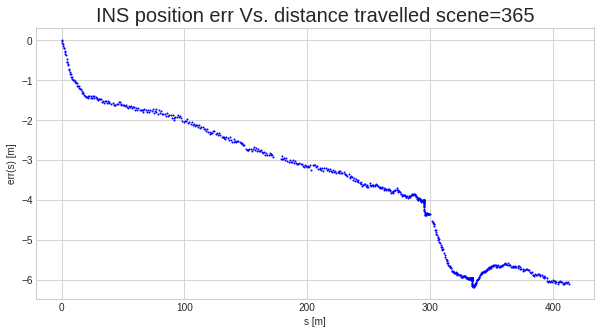

In [131]:
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800
gt = np.zeros(N)
imu = np.zeros(N)
gt_pos = np.zeros((N,2))
imu_pos = np.zeros((N,2))
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt[t] = np.linalg.norm(trns[0:2]-gt_pos[t-1, :]) if t > 0 else 0
    gt_pos[t, :] = trns[0:2]
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    print("gt", trns, "ins", trns1)
    imu[t] = np.linalg.norm(trns1[0:2]-imu_pos[t-1, :]) if t > 0 else 0
    imu_pos[t, :] = trns1[0:2]
    timestamp[t] = dataset.odometry['timestamp']
    
gt_int = np.cumsum(gt)
imu_int = np.cumsum(imu)
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS position err Vs. distance travelled scene={scene}", fontsize=20)
ax.set(xlabel='s [m]', ylabel='err(s) [m]')
ax.scatter(gt_int,gt_int-imu_int,color='blue',s=1)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]


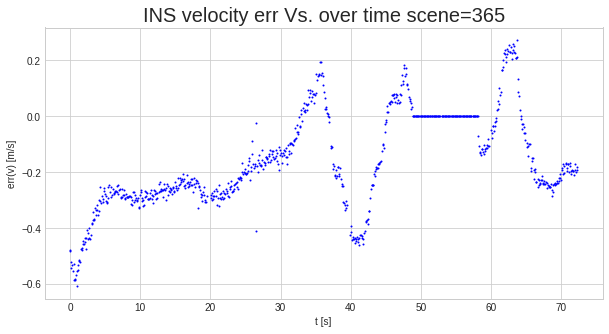

In [134]:
#draw the speed
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800#800
gt_speed = np.zeros(N)
imu_speed = np.zeros(N)
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt_speed[t] = np.linalg.norm(dataset.odometry['speed'])
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    imu_speed[t] = dataset.odometry['speed']
    timestamp[t] = dataset.odometry['timestamp']
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS velocity err Vs. over time scene={scene}", fontsize=20)
ax.set(xlabel='t [s]', ylabel='err(v) [m/s]')
ax.scatter(timestamp[:]-timestamp[0],gt_speed-imu_speed,color='blue',s=1)

In [ ]:
from pyquaternion import Quaternion

Quaternion.Inverse()

In [ ]:
dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=426)
_, _, _, video_data, nusc_map = dataset.getData(700)
map_matching = MapMatching(N=10)

In [ ]:
edges1 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['walkway'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges2 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['drivable_area'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges = edges1 & edges2

#road = map_matching.getDrivableArea(nuscMap=nusc_map, worldRef=[400,850],layer_names = ['drivable_area'], patch_size=200)
plt.imshow(edges2, origin='lower')

In [ ]:
a = np.array([[1, 2],[3,4],[5,6],[7,8]])
print(a.shape)
b = np.array([[11, 19],[7,28],[15,16]]).T
print(b.shape)
print(a[:,0].shape)
k = a[:,0].reshape(-1,1)-b[0,:].reshape(1,-1)
t = a[:,1].reshape(-1,1)-b[1,:].reshape(1,-1)
norm = np.sqrt(k**2 + t**2)
it = norm.argmin(axis=1)
print("it", it, "norm",norm)
#print(np.amin(norm, axis=1))
print(k.shape, t.shape)
print(k)
print(np.take_along_axis(k, np.expand_dims(it, axis=-1), axis=1))
print(np.take_along_axis(t, np.expand_dims(it, axis=-1), axis=1))

In [30]:
A = np.zeros((3,3))
pnts = [[0,1],[3,3],[6,1]]
dist = np.array([pnt[0]**2 for pnt in pnts])
candidates = np.where(dist>5)[0]
non_candidates = np.where(dist<=5)[0]

A[candidates,0] = 1
print(A)

[[0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
